Eigenvalue neural network for the infinite potential well, based on the code by henry1jin (https://github.com/henry1jin/eigeNN)

In [2]:
from torch.autograd import Variable
from torch.autograd import grad
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torch
import copy
import time

dtype=torch.float

In [3]:
class mySin(torch.nn.Module):
    """Sine activation function as a PyTorch Module 
    (Base class for all neural network modules.)"""
    @staticmethod
    def forward(input):
        return torch.sin(input)

def dfx(x,f):   
    """ Derivatives with Auto-differention
        -----------------------------------
        x: variable
        f: function 
        --------------------------------"""
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def parametricSolutions(x, nn, xl, xr, f0):
    """ Parametric solution to enforce boundary conditions
        in 1D and when f(xl) = f(xr) = f0.
        --------------------------------------------------
        x : variable domain
        nn: neural network model 
        xl: boundary coordinate (Left)
        xr: boundary coordinate (Right)
        f0: function value at the boundary
        -----------------------------------------------"""
    N1,N2 = nn(x)     #Outputs of the neural network at each point of the domain
    return f0  + (1-torch.exp(xl-x))*(1-torch.exp(xr-x)) * N1  

def FreeParticle_Loss(x,ψ,λ):
    """ Loss function associated with the differential equation
        (Shrödinger equation for a free particle)
        --------------------------------------------------------
        x : variable domain
        ψ : incognite function
        λ  : eigenvalue (energy)
        ---------------------------------------------------- """
    ψ_dx = dfx(x,ψ)    #First derivative
    ψ_ddx= dfx(x,ψ_dx) #Second derivative
    f = ψ_ddx/2 + λ*ψ  #Differential equation
    Loss  = (f.pow(2)).mean(); #Mean square loss
    return Loss

In [4]:
class NN(torch.nn.Module):
    """Neural Network with two layers"""
    def __init__(self, D_hid=10): #Elements of the model
        """D_hid: Numeber of hidden layers"""
        #Initialize super class
        super(NN,self).__init__()
        # Define the Activation  
        self.actF = mySin()
        # Define layers
        self.Ein    = torch.nn.Linear(1,1)            #For the eigenvalues
        self.Lin_1  = torch.nn.Linear(2, D_hid)       #Two inputs (x and λ)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)   #Fully connected layer
        self.out    = torch.nn.Linear(D_hid, 1)       #One output (ψ(x))

    def forward(self,x):           #What the model does
        In1 = self.Ein(torch.ones_like(x))
        L1 = self.Lin_1(torch.cat((x,In1),1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        out = self.out(h2)
        return out, In1  #Returns ψ(x) and E  

In [5]:
def Scan_Well(x0, xf, ψ0, NpL, epochs, n_train, lr, explore, tol, new):
    """Explore the space of eigenvalues to find different solutions 
        to the ODE associated to a Infinite Potential Well
        ------------------------------------------------------------------
        x0       : boundary coordinate (Left)
        xf       : boundary coordinate (Rigth)
        ψ0       : function value at the boundary
        NpL      : number of neurons per layer 
        epochs   : number of training epochs
        n_train  : number of points in the domain if training
        lr       : learning rate
        explore  : number of epochs before changing cost function (drive)
        tol      : tolerance criteria for acceptance  of eigenvalue
        new      : criteria for distintion between eigenvalues                 
        ---------------------------------------------------------------"""
    #Creates neural network
    eigenNN = NN(NpL)    
    #Creates Adam optimizer
    optimizer = optim.Adam(eigenNN.parameters(), lr=lr, betas=[0.999, 0.9999]) 
    #Arrays for saving data
    Total_loss     = []   
    ODE_loss       = []
    Drive_loss     = []
    NonTriv_loss   = []
    E_NonTriv_loss = []
    Energy         = []
    #Dictionary for saving models with different eigenvalues
    dic = {0:(None, None), 1:(None, None), 2:(None, None), 3:(None, None), 4:(None, None), 5:(None, None)}
    #Discretization of the solution
    x = torch.linspace(x0, xf, n_train).reshape(-1,1)
    x.requires_grad = True
    #Starts training    
    T0   = time.time() #Initial (real) time
    cte  = -4          #Initial constant for the drive
    n    = 0           #Eigenvalue conter (starts in zero)
    for tt in range(epochs):
        #Network solutions 
        out, En = eigenNN(x)
        #Saves Eigenvalue given by the network
        λ = En[0].data.tolist()[0]
        Energy.append(λ)
        #Parametrizes solution
        ψ  = parametricSolutions(x, eigenNN, x0, xf, ψ0)
        #Losses
        lossODE = FreeParticle_Loss(x, ψ, En); ODE_loss.append(lossODE.detach().numpy())
        lossNT = 1/((ψ.pow(2)).mean()+1e-6); NonTriv_loss.append(lossNT.detach().numpy())
        lossENT = 1/(En.pow(2).mean()+1e-6); E_NonTriv_loss.append(lossENT.detach().numpy())
        lossD  = torch.exp(-1*En+cte).mean(); Drive_loss.append(lossD.detach().numpy()) 
        lossT = lossODE + lossNT +  lossENT + lossD; Total_loss.append(lossT.detach().numpy())
        #Applies backprop
        optimizer.zero_grad()              
        lossT.backward(retain_graph=False) 
        optimizer.step()                   
        # Updates cte for the drive cost function
        if tt%explore == 0:
            cte += 1
            # If there has been convergence to an eigenvalue, saves the model into the dictionary
            if tt > 1000 and np.var(np.array(Energy[tt-1000:tt])) < tol: 
                if n == 0:
                    dic[n] = (copy.deepcopy(eigenNN), λ)
                    print("Eigenvalue founded!\tEnergy = ",'{0:.3g}'.format(λ),
                          "\tEpoch =",tt,
                          "\tTime = ",'{0:.3g}'.format((time.time()- T0)/60)," min") 
                    n += 1
                #Checks if an eigenvalue has been found before
                elif abs((λ-dic[n-1][1])/dic[n-1][1]) > new:
                    dic[n] = (copy.deepcopy(eigenNN), λ)
                    print("Eigenvalue founded!\tEnergy = ",'{0:.3g}'.format(λ),
                          "\tEpoch =",tt,
                          "\tTime = ",'{0:.3g}'.format((time.time()- T0)/60)," min")
                    n += 1
        #Ends the training if five eigenvalues have been found
        if n == 5:
            break
    #Training time          
    runTime = time.time() - T0
    #Saves all losses in one object
    loss_histories = (Total_loss, ODE_loss, Drive_loss, NonTriv_loss, E_NonTriv_loss)
    return dic, loss_histories, Energy, runTime

In [6]:
#Boundaries 
xl = 0.
xr = 1.
ψ0 =0.
#Seed for reproducibility 
torch.manual_seed(0)
#Parameters
n_train, neurons, epochs, lr, explore, tol, new = 100, 50, int(125e3), 8e-3, 2500, 1e-5, 1e-2 
#Training!
Model ,loss_histories, Energy, runTime = Scan_Well(xl, xr, ψ0, neurons, epochs, 
                                                    n_train, lr, explore, tol, new)
print('Training time (minutes):', runTime/60)

Eigenvalue founded!	Energy =  4.93 	Epoch = 15000 	Time =  1.74  min
Eigenvalue founded!	Energy =  19.7 	Epoch = 52500 	Time =  6.34  min
Eigenvalue founded!	Energy =  44.4 	Epoch = 105000 	Time =  15.2  min
Training time (minutes): 18.648433450857798


# Cost function

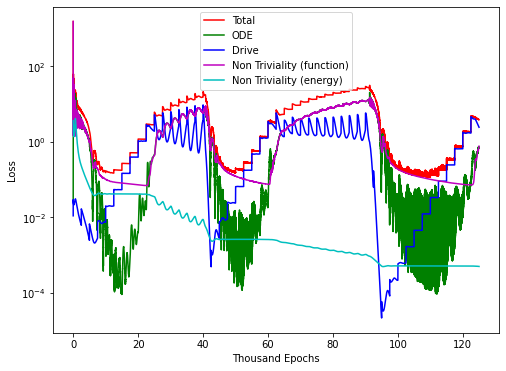

In [7]:
plt.figure(figsize = (8,6))
plt.semilogy(np.arange(epochs)/1000,loss_histories[0],'-r', label = 'Total')
plt.semilogy(np.arange(epochs)/1000,loss_histories[1],'-g', label = 'ODE')
plt.semilogy(np.arange(epochs)/1000,loss_histories[2],'-b', label = 'Drive')
plt.semilogy(np.arange(epochs)/1000,loss_histories[3],'-m', label = 'Non Triviality (function)')
plt.semilogy(np.arange(epochs)/1000,loss_histories[4],'-c', label = 'Non Triviality (energy)')
plt.ylabel('Loss');plt.xlabel('Thousand Epochs')
plt.legend()

# Energy

Text(0.5, 0, 'Thousand Epochs')

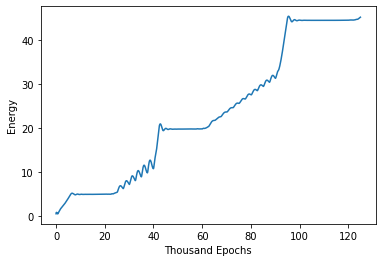

In [8]:
plt.plot(np.arange(epochs)/1000, Energy)
plt.ylabel('Energy');plt.xlabel('Thousand Epochs')

# Solution

In [9]:
#Predicted solutions
X = torch.linspace(xl,xr,n_train)
X = X.reshape(-1,1)
X.requires_grad=True
X_numpy = X.detach().numpy()

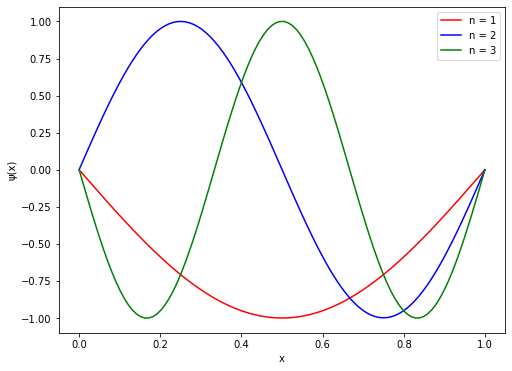

In [10]:
plt.figure(figsize = (8,6))

A = parametricSolutions(X,Model[0][0],xl,xr,ψ0).data.numpy() 
B = parametricSolutions(X,Model[1][0],xl,xr,ψ0).data.numpy()
C = parametricSolutions(X,Model[2][0],xl,xr,ψ0).data.numpy()
#Plots normalized solutions
plt.plot(X_numpy, A/np.max(np.abs(A)), '-r', label = 'n = 1')
plt.plot(X_numpy, B/np.max(np.abs(B)), '-b', label = 'n = 2')
plt.plot(X_numpy, C/np.max(np.abs(C)), '-g', label = 'n = 3')
plt.ylabel('ψ(x)');plt.xlabel('x')
plt.legend()